<a href="https://colab.research.google.com/github/malofeevakate/bootstrap_research/blob/main/bootstrap_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1),
            replace = True # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            len(data_column_1),
            replace = True
        ).values

        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"quants": quants,
            "p_value": p_value}

In [6]:
# считаем данные
df = pd.read_csv('hw_bootstrap (1).csv', sep = ';', index_col = 0, decimal = ',')

In [7]:
df

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control
...,...,...
996,1000.000000,Treatment
997,1200.000000,Treatment
998,1500.000000,Treatment
999,2000.000000,Treatment


In [ ]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

In [8]:
# посмотрим на размеры теста и контроля
df.groupby('experimentVariant').agg({'value': 'count'})

,value
experimentVariant,
Control,500
Treatment,500


In [ ]:
# сравним их средние
df.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,27.321499


In [ ]:
# и медианы
df.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.025847


<AxesSubplot:xlabel='experimentVariant', ylabel='value'>

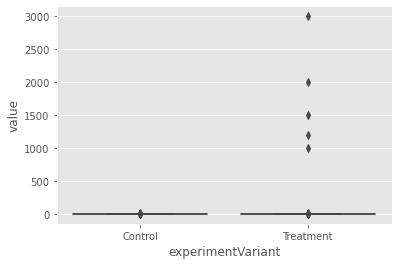

In [ ]:
# при построении боксплотов уже видно, что тестовая группа отличается большим количеством выбросов
sns.boxplot(x="experimentVariant", y="value", data=df)

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value'>

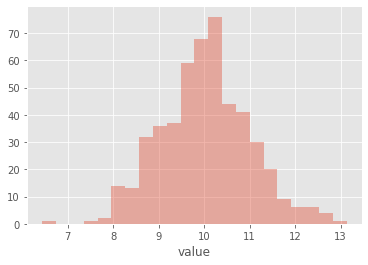

In [ ]:
# распределение контрольной группы внешне похоже на нормальное
sns.distplot(df[df.experimentVariant == 'Control'].value, kde=False)

<AxesSubplot:xlabel='value'>

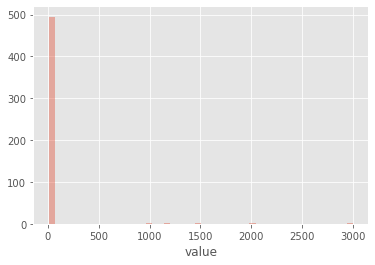

In [ ]:
# чего не скажешь о тестовой
sns.distplot(df[df.experimentVariant == 'Treatment'].value, kde=False)

In [ ]:
# Манн-Уитни не позволяет отвергнуть нулевую гипотезу об однородности выборок
mannwhitneyu(df[df.experimentVariant == 'Treatment'].value,
             df[df.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

In [ ]:
# а t-test дает значимые различия средних
ttest_ind(df[df.experimentVariant == 'Treatment'].value,
             df[df.experimentVariant == 'Control'].value)

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

  0%|          | 0/1000 [00:00<?, ?it/s]

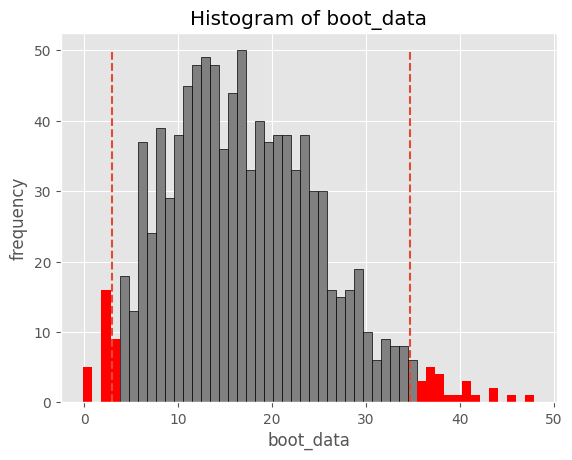

{'quants':                0
 0.025   2.946200
 0.975  34.734067,
 'p_value': 0.039039455265599696}

In [9]:
# посмотрим на бутстрэп по среднему
get_bootstrap(
    df[df.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    df[df.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

  0%|          | 0/1000 [00:00<?, ?it/s]

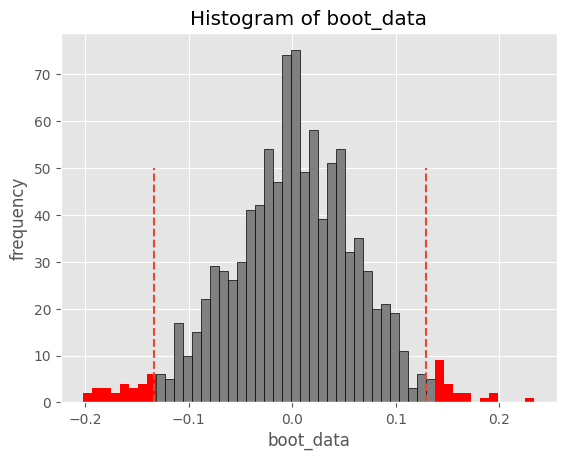

{'quants':               0
 0.025 -0.133769
 0.975  0.129635,
 'p_value': 0.9865001964340468}

In [10]:
# посмотрим на бутстрэп по медиане
get_bootstrap(
    df[df.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    df[df.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

**Бутстрэп по среднему и т-тест** дали оба p_value < 0.05, что предполагает **отвержение нулевой гипотезы** о равенстве средних. **Манн-Уитни** наоборот говорит, что **недостаточно оснований** считать, что тестовое и контольное распределение значимо различны. Но посмотрим на визуализацию наших выборок: если контроль распределен более - менее равномерно, то в тестовой группе значения в основном пляшут около 10, но имеются просто ужасающие выбросы.  Попробуем убрать выбросы и повторить тесты

In [11]:
df1 = df.iloc[0:995]

In [12]:
# размеры теста и контроля не сильно отличаются
df1.groupby('experimentVariant').agg({'value': 'count'})

,value
experimentVariant,
Control,500
Treatment,495


In [ ]:
# средние тоже практически одинаковые, в противовес первоначальному результату (различались вдвое)
df1.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,10.021716


In [ ]:
# аналогично медианы
df1.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.015492


<AxesSubplot:xlabel='experimentVariant', ylabel='value'>

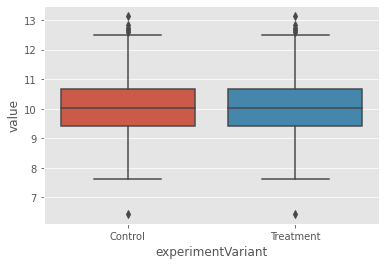

In [ ]:
# боксплоты демонстрируют практически аналогичность тестовой и контрольной групп
sns.boxplot(x="experimentVariant", y="value", data=df1)

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value'>

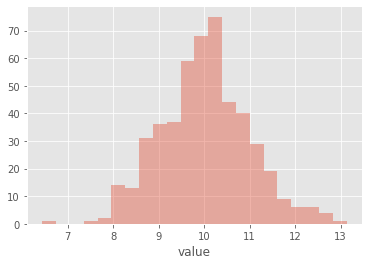

In [ ]:
# тест стал практически нормально распределен
sns.distplot(df1[df1.experimentVariant == 'Treatment'].value, kde=False)

In [ ]:
# Манн-Уитни все также не позволяет отвергнуть нулевую гипотезу об однородности выборок
mannwhitneyu(df1[df1.experimentVariant == 'Treatment'].value,
             df1[df1.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=123310.5, pvalue=0.4614193132073732)

In [ ]:
# а t-test также показывает, что тест и контроль одинаковы
ttest_ind(df1[df1.experimentVariant == 'Treatment'].value,
             df1[df1.experimentVariant == 'Control'].value)

Ttest_indResult(statistic=-0.08299135107595523, pvalue=0.9338751428058142)

  0%|          | 0/1000 [00:00<?, ?it/s]

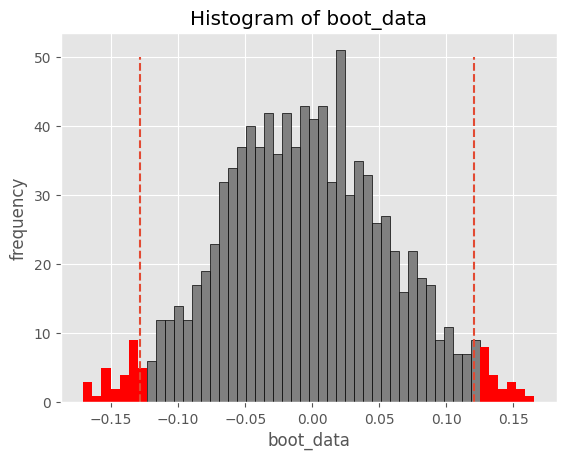

{'quants':               0
 0.025 -0.128661
 0.975  0.120603,
 'p_value': 0.9295660224792556}

In [13]:
# и бутстрэп дает замечательный результат
get_bootstrap(
    df1[df1.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    df1[df1.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

## Итого
* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
* Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
* U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы